# fig6_upper
SALLJ composites of 250-hPa geopotential heights (contour lines), isotachs (contour shading), and wind vectors


## Imports

In [1]:
# Standard Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units


In [2]:
# Set up paths
home = Path.home()                 # users home directory
root = home/'repos'/'montini-phd'    # project root directory
path_to_data = root/'data'           # data directory (input data, read only)
path_to_out = root/'out'             # directory for storing numerical results and intermediate datafiles (read & write
path_to_figs = root/'figs'           # directory for storing figures


In [3]:
# Path to modules directory
path_to_mods = os.fspath(root/'modules')
sys.path.append(path_to_mods)

# Import my modules
from plotter import draw_basemap


In [4]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


## Data

### SALLJ days

In [5]:
filepath = path_to_out / 'sallj-types-ndjfm.csv'
df = pd.read_csv(filepath)


### ERA5 renalysis

In [6]:
# Load reanalysis data
f1 = xr.open_dataset(path_to_data/'era5_zg_250_day_1979-2016_spac.nc')
f2 = xr.open_dataset(path_to_data/'era5_ua_250_day_1979-2016_spac.nc')
f3 = xr.open_dataset(path_to_data/'era5_va_250_day_1979-2016_spac.nc')

# merge variables into single dataset
era = xr.merge([f1,f2,f3])

# Trim date range
start_date = '1979-11-01'
end_date = '2016-03-31'
idx = slice(start_date, end_date)
era = era.sel(time=idx)

# Select NDJFM months
idx = (era.time.dt.month >= 11) | (era.time.dt.month <= 3)
era = era.sel(time=idx)
#print(era, '\n')


In [7]:
# Combine SALLJ data w/ reanalysis data

# Add llj time series to the ERA dataset
era['llj'] = ('time', df.LLJ_CAT)
era = era.set_coords('llj')

# Select only LLJ days
idx = (era.llj >= 1)
era_llj = era.sel(time=idx)
#print(era_llj)


### Composites of SALLJ types

In [8]:
# Compute composites of each SALLJ type
era_llj_comp = era_llj.groupby('llj').mean('time')
print(era_llj_comp)


<xarray.Dataset>
Dimensions:    (latitude: 161, llj: 4, longitude: 307)
Coordinates:
  * latitude   (latitude) float32 20.0 19.5 19.0 18.5 ... -59.0 -59.5 -60.0
  * longitude  (longitude) float32 -165.0 -164.5 -164.0 ... -13.0 -12.5 -12.0
  * llj        (llj) int64 1 2 3 4
Data variables:
    zg         (llj, latitude, longitude) float32 10876.022 ... 9833.448
    ua         (llj, latitude, longitude) float32 17.707651 ... 17.161108
    va         (llj, latitude, longitude) float32 -6.418577 ... 4.6591196


## Figure 6

### Data for plotting

In [9]:
# lat/lon arrays
lats = era_llj_comp.latitude.values
lons = era_llj_comp.longitude.values

# 250-hPa Heights
hgts = era_llj_comp.zg.values

# 250-hPa Winds (m/s)
uwnd = era_llj_comp.ua.values * units('m/s')
vwnd = era_llj_comp.va.values * units('m/s')
wspd = mpcalc.wind_speed(uwnd, vwnd)

# 250-hPa Winds (knots)
uwnd_kt = wspd.to('kt')
vwnd_kt = wspd.to('kt')
wspd_kt = wspd.to('kt')

### Set plot parameters

In [10]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Projection/Coordinate systems
datacrs = ccrs.PlateCarree()     # data/source
mapcrs = ccrs.PlateCarree()      # map/destination

# Map Boundaries
lonmin = -120
lonmax = -12
latmin = -60
latmax = 20

# Tickmark/Gridline Locations
dx = np.arange(-90,lonmax,30)
dy = np.arange(-30,latmax,30)

# Labels
plt_labels = ['SALLJ Type 1', 'SALLJ Type 2', 'SALLJ Type 3','SALLJ Type 4']


### Create figure

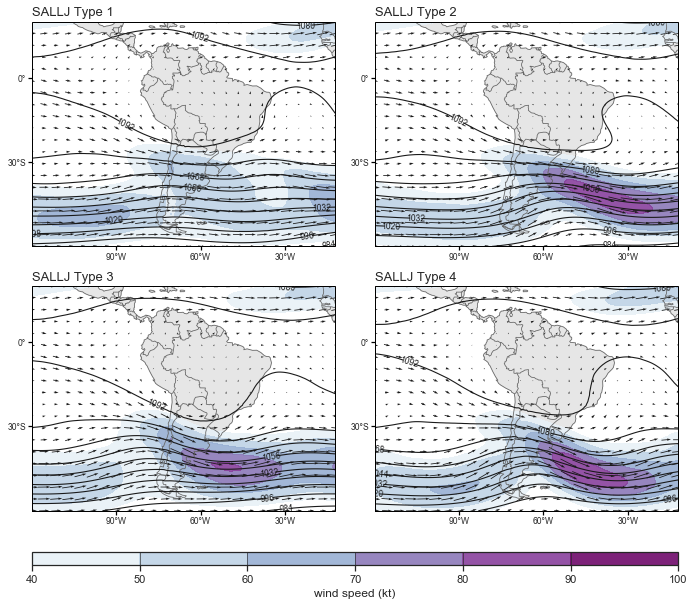

In [14]:
 # Create figure
fig = plt.figure(figsize=(15,10))
nrows = 2
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.02, cbar_size='3%',label_mode='')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Wind Speed (contour filled)
    clevs_wspd = np.arange(40,101,10)
    cf = ax.contourf(lons, lats, wspd_kt[k,:,:], transform=datacrs,
                     levels=clevs_wspd, cmap='BuPu', alpha=0.9)
    
    # Geopotenital height lines
    clevs_hgts = np.arange(840,1280,12)
    cs = ax.contour(lons, lats, hgts[k,:,:]/10., transform=datacrs,
                    levels=clevs_hgts, colors='k', linewidths=1.1)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)  
        
    # Wind barbs / vectors 
    ax.quiver(lons, lats, uwnd[k,:,:], vwnd[k,:,:], transform=datacrs, 
             color='k', regrid_shape=20, pivot='middle')
   # subtitles 
    ax.set_title(plt_labels[k], loc='left',fontsize=13)
    
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, extend='both')
cb.set_label('wind speed (kt)')

# Save figure
filepath = path_to_figs / 'fig6.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()
